In [1]:
# Standard library imports
import logging
import warnings
from pathlib import Path

# Third-party imports
import pandas as pd
import wrds

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

from settings import config
from pull_compustat import *
from pull_crsp import *
from transform_crsp import *
from transform_compustat import *

In [2]:
# Change default pandas display options

pd.options.display.max_columns = 30
pd.options.display.max_colwidth = 200
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.expand_frame_repr', False)

# Global variables
RAW_DATA_DIR = Path(config("RAW_DATA_DIR"))
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR = Path(config("OUTPUT_DIR"))
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
WRDS_USERNAME = config("WRDS_USERNAME")
START_DATE = config("START_DATE")
END_DATE = config("END_DATE")

In [3]:
crsp_d = pull_CRSP_stock(
    start_date=START_DATE,
    end_date=END_DATE,
    wrds_username=WRDS_USERNAME,
    freq='D',
    data_dir=RAW_DATA_DIR,
    file_name='CRSP_stock_d.parquet',
)

Loading cached data from C:\Users\eduar\Documents\data\raw\CRSP_stock_d.parquet


In [4]:
crsp_m = pull_CRSP_stock(
    start_date=START_DATE,
    end_date=END_DATE,
    wrds_username=WRDS_USERNAME,
    freq='M',
    data_dir=RAW_DATA_DIR,
    file_name='CRSP_stock_m.parquet',
)

Loading cached data from C:\Users\eduar\Documents\data\raw\CRSP_stock_m.parquet


In [5]:
comp = pull_Compustat(
    start_date=START_DATE,
    end_date=END_DATE,
    wrds_username=WRDS_USERNAME,
    data_dir=RAW_DATA_DIR,
    file_name='Compustat_fund.parquet',
)

Loading cached data from C:\Users\eduar\Documents\data\raw\Compustat_fund.parquet


In [6]:
ccm = pull_CRSP_Comp_link_table(
    wrds_username=WRDS_USERNAME,
    data_dir=RAW_DATA_DIR,
    file_name="CRSP_Comp_Link_Table.parquet"
    )

Loading cached data from C:\Users\eduar\Documents\data\raw\CRSP_Comp_Link_Table.parquet


In [7]:
crsp_index_d = pull_CRSP_index(
    start_date=START_DATE,
    end_date=END_DATE,
    freq='D',
    wrds_username=WRDS_USERNAME,
    file_name="CRSP_index_d.parquet")

Loading cached data from C:\Users\eduar\Documents\data\raw\CRSP_index_d.parquet


In [8]:
# 2) Calculate market equity
crsp = calculate_market_equity(crsp_m)

# 2) Add report date and calculate book equity
comp = add_report_date(comp)
comp = calc_book_equity(comp)
comp = expand_compustat_annual_to_monthly(comp)


In [9]:
# 3) Merge comp + crsp_m + ccm => crsp_comp
crsp_comp = merge_CRSP_and_Compustat(crsp, comp, ccm)

In [10]:
from calc_Lewellen_2014 import *

In [11]:
crsp_comp          = calc_log_size(crsp_comp)

In [12]:
crsp_comp            = calc_log_bm(crsp_comp)

In [13]:
crsp_comp       = calc_return_12_2(crsp_comp)

In [14]:
crsp_comp          = calc_accruals(crsp_comp) 

In [15]:
crsp_comp               = calc_roa(crsp_comp)

In [16]:
crsp_comp = calc_log_assets_growth(crsp_comp)

In [17]:
crsp_comp                = calc_dy(crsp_comp)

In [18]:
crsp_comp  = calc_log_return_13_36(crsp_comp)

In [19]:
crsp_comp     = calc_log_issues_12(crsp_comp)

In [20]:
crsp_comp     = calc_log_issues_36(crsp_comp)

In [21]:
crsp_comp        = calc_debt_price(crsp_comp)

In [22]:
crsp_comp       = calc_sales_price(crsp_comp)

In [23]:
crsp_comp = calc_std_12(crsp_d, crsp_comp)


In [24]:
crsp_comp = calculate_rolling_beta(crsp_d, crsp_index_d, crsp_comp)

In [25]:
# Winsorize the variables to remove outliers
variables_dict = {
    "Return (%)":                "retx",                # Assuming you are keeping this column name
    "Log Size (-1)":             "log_size",
    "Log B/M (-1)":              "log_bm",
    "Return (-2, -12)":          "return_12_2",
    "Log Issues (-1,-12)":       "log_issues_12",
    "Accruals (-1)":             "accruals_final",
    "ROA (-1)":                  "roa",
    "Log Assets Growth (-1)":    "log_assets_growth",
    "Dividend Yield (-1,-12)":   "dy",
    "Log Return (-13,-36)":      "log_return_13_36",
    "Log Issues (-1,-36)":       "log_issues_36",
    "Beta (-1,-36)":             "beta",
    "Std Dev (-1,-12)":          "rolling_std_252",
    "Debt/Price (-1)":           "debt_price",
    "Sales/Price (-1)":          "sales_price",
    }
crsp_comp = winsorize(crsp_comp, variables_dict.values())

In [50]:
subsets_comp_crsp = get_subsets(crsp_comp) 

In [27]:
table_1 = build_table_1(subsets_comp_crsp, variables_dict)

In [28]:
table_1

all_stocks                 all_but_tiny_stocks                 large_stocks               
                               Avg      Std      N                 Avg      Std      N          Avg      Std     N
Column                                                                                                            
Return (%)                  0.0093   0.1288  22433              0.0152   0.0998  12216       0.0144   0.0862  5941
Log Size (-1)              11.4588   1.9125  22394             13.1972   1.1851  12139      14.1339   0.9094  5893
Log B/M (-1)               -7.3854   1.0380  22394             -7.5769   0.9035  12139      -7.6248   0.8353  5893
Return (-2, -12)            0.1137   0.4797  21273              0.1727   0.4193  11114       0.1648   0.3657  5469
Log Issues (-1,-12)         0.0704   0.2172  21274              0.0957   0.2201  11119       0.1001   0.2268  5470
Accruals (-1)            -109.1113 520.1802  18845           -210.6996 710.6625  10303    -360.7039 884.0736  4998
ROA (-1)                    0.0058   0.1516  22414              0.0473   0.0884  12199       0.0569   0.0684  5931
Log Assets Growth (-1)      0.1186   0.2676  21274              0.1470   0.2280  11119       0.1377   0.1989  5470
Dividend Yield (-1,-12)    11.1235  38.0712  22369             20.2079  49.5919  12117      32.4352  60.6684  5879
Log Return (-13,-36)        0.0274   0.6002  17317              0.1682   0.4809   9262       0.1912   0.4300  4755
Log Issues (-1,-36)         0.2203   0.4377  17325              0.3012   0.4258   9263       0.3206   0.4348  4756
Beta (-1,-36)               0.7247   0.6003   1650              0.8659   0.4062    545       0.8646   0.5723   153
Std Dev (-1,-12)            0.0326   0.0178  22286              0.0237   0.0098  11965       0.0209   0.0078  5824
Debt/Price (-1)             0.0014   0.0043  22316              0.0009   0.0027  12083       0.0007   0.0019  5871
Sales/Price (-1)            0.0034   0.0084  22333              0.0020   0.0046  12096       0.0016   0.0029  5874

In [96]:
table_2 = build_table_2(subsets_comp_crsp, factors_dict)

TypeError: boolean value of NA is ambiguous

(<Figure size 1400x1000 with 2 Axes>,
 array([<Axes: title={'center': 'Panel A: All Stocks (10-Year Rolling Slopes)'}, ylabel='Slope Coefficient'>,
        <Axes: title={'center': 'Panel B: Large Stocks (10-Year Rolling Slopes)'}, xlabel='Month', ylabel='Slope Coefficient'>],
       dtype=object))

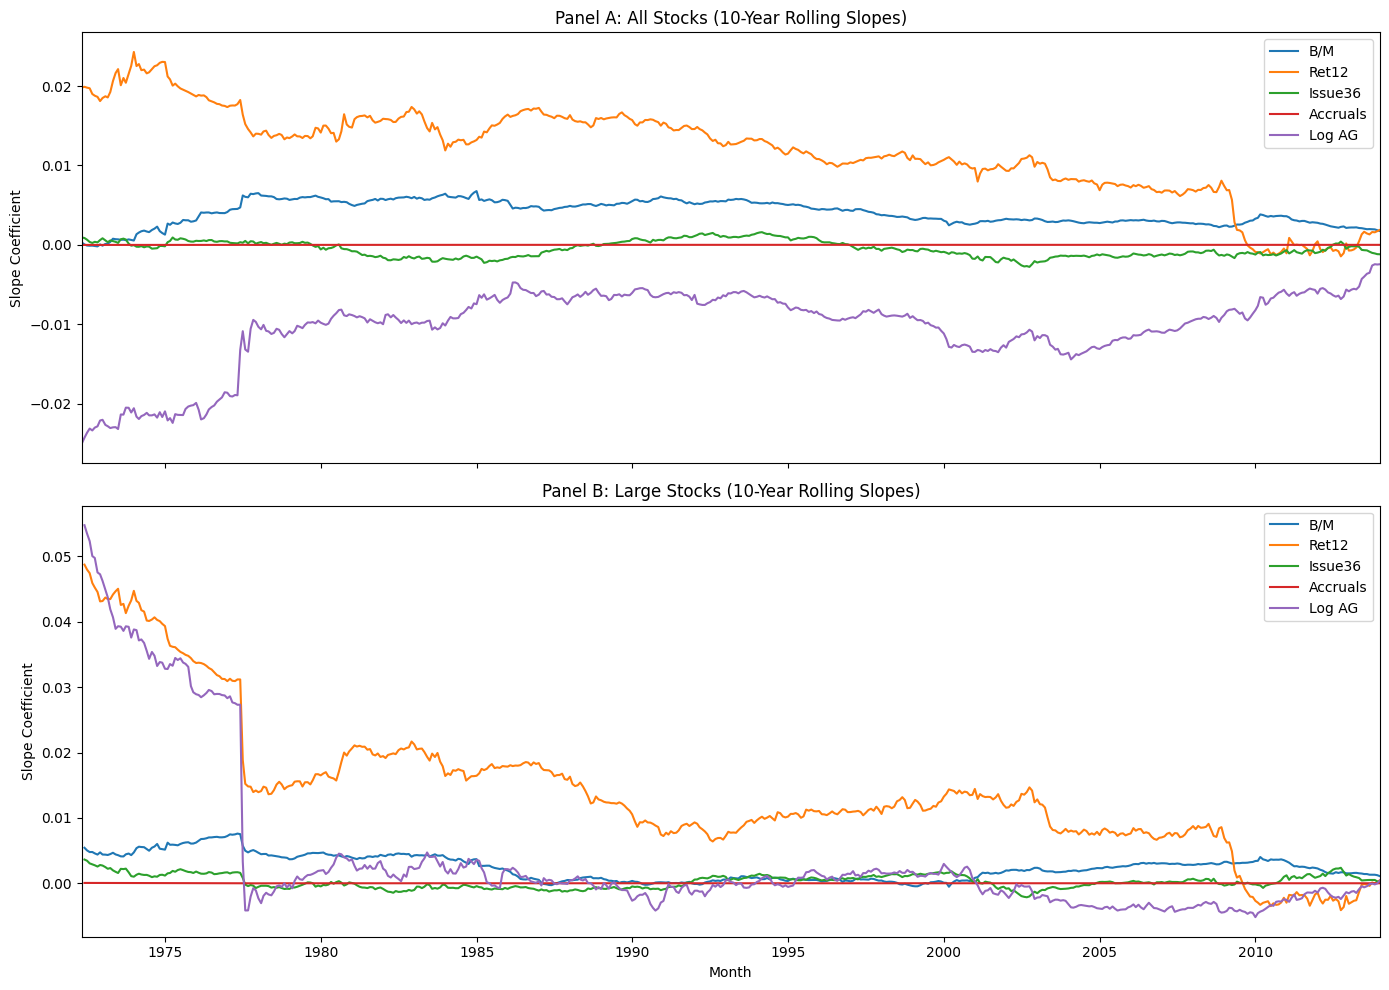

In [70]:
create_figure_1(subsets_comp_crsp)